В цьому домашньому завданні ми проведемо додаткові експерименти для рішення задачі бінарної класифікації і створимо ваш новий submission на змагання на Kaggle.

-----------


**Завдання 0**. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/competitions/bank-customer-churn-prediction-dlu-course-c-2). Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

**Завдання 1**. **Збираємо весь код з попереднього ДЗ в одному місці.** В лекційному ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb` ми познайомились з поняттям пайплайнів, а також я показала, як компактно виглядає рішення МЛ задачі, якщо ми зберемо весь код разом.

Оскільки ми далі будемо робити експерименти, які включають ті самі етапи попередньої обробки, але інше моделювання - буде зручно мати весь код компактно і під рукою. Тому зараз ми займемось збором коду до купи :) Після цього завдання для подальших експериментів ви можете перенести частини розвʼязку взагалі в окремий `.py` файл, аби було зручно імпортувати функції.

Зі свого рішення в попередньому домашньому завданні (`Логістична регресія з scikit learn.ipynb`) зберіть усі кроки розвʼязку задачі разом з використанням `sklearn.Pipeline` за прикладом з лекції.

Ваш код нижче має містити
1. Читання даних з файлу (поза пайплайном).
2. Розбиття на тренувальний і валідаційний набори, де валідаційний містить 20% даних (поза пайплайном).
3. Виділення категоріальних і числових колонок (поза пайплайном).
4. Підготовку категоріальних і числових колонок (частина пайплайну). В прикладі в лекції ми оформлювали обробку числових і категоріальних колонок в окремі трансформери `numeric_transformer`, `categorical_cols`. Рекоемндую зробити саме так, так потім зручніше вносити зміни :)
5. Тренування лог регресії (частина пайплайну).
6. Запуск пайплайну на тренування на трен. даних (поза пайплайном).
7. Запуск пайплайну на передбачення на трен і вал. даних і вимір метрик якості ROC-AUC + вивдення Confusion Matrix (поза пайплайном).
8. Збереження моделі в формат joblib (поза пайплайном).

Ви це все вже зробили в попереднтьому ДЗ! Тож, тут просто заадча все зібрати разом.

Нижче я додала підказки, що покроково ви маєте зробити. Якщо ви почуваєтесь впевнено, можете видалити ці підказки і реалізувати все самостійно, або ж - просто заповнити пропуски.

Завдання оцінюється в 10 балів. Головний результат - аби код в фіналі був робочий. Бо за не робочий нам гроші ніхто не заплатить :)

In [93]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, FunctionTransformer, StandardScaler, RobustScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, roc_curve, auc, root_mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from operator import pos

F1 SCORE for Training: 0.65
Area under ROC score on Training dataset: 0.88%


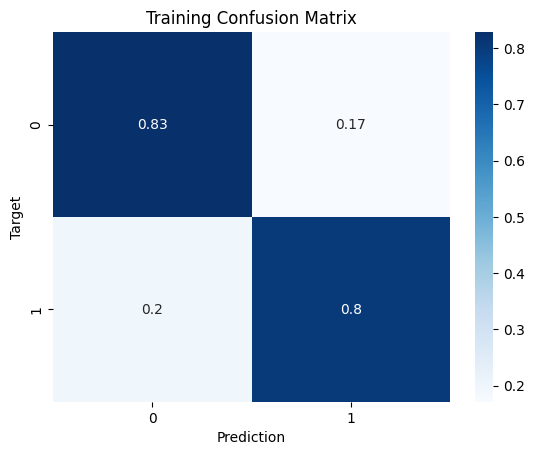

F1 SCORE for Validation: 0.63
Area under ROC score on Validation dataset: 0.88%


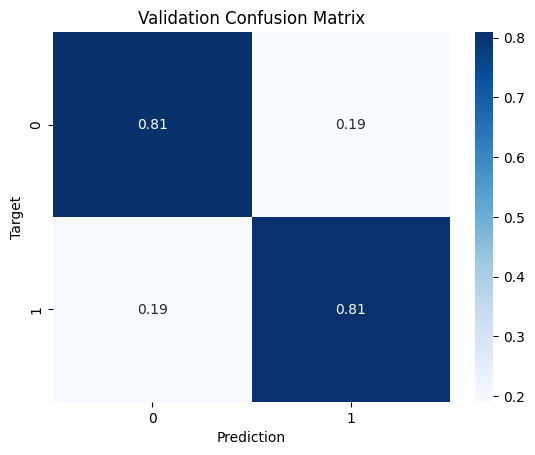

['model_pipeline.pkl']

In [53]:
raw_df = pd.read_csv("train.csv", index_col=0)

train_df, val_df = train_test_split(raw_df, test_size=0.2, random_state=42, stratify=raw_df.Exited)

# Створюємо трен. і вал. набори
input_cols = list(train_df.columns)[2:-1]
target_col = 'Exited'
train_inputs, train_targets = train_df[input_cols], train_df[target_col]
val_inputs, val_targets = val_df[input_cols], val_df[target_col]


# Виявляємо числові і категоріальні колонки
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes(include='object').columns.tolist()

# Створюємо трансформери для числових і категоріальних колонок
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# Комбінуємо трансформери для різних типів колонок в один препроцесор
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Стоврюємо пайплайн, який спочатку запускає препроцесинг, потім тренуєм модель
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', class_weight='balanced'))
])

# Тренуємо пайплайн
model_pipeline.fit(train_inputs, train_targets)

# Функція, щоб передбачати і рахувати метрики
def predict_and_plot(model_pipeline, inputs, targets, name='', pos_label = None, threshold=0.5):
    y_pred_proba = model_pipeline.predict_proba(inputs)[:, 1]
    preds = (y_pred_proba >= threshold).astype(int)

    # f1_score
    f1 = f1_score(targets, preds)
    print(f'F1 SCORE for {name}: {f1:.2f}')

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(targets, y_pred_proba, pos_label = pos_label)

    # Compute AUROC
    roc_auc = auc(fpr, tpr)
    print(f"Area under ROC score on {name} dataset: {roc_auc:.2f}%")
    confusion_matrix_ = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(confusion_matrix_, annot=True, cmap='Blues')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name))
    plt.show()
    return preds

# Оцінюємо модель на трен і вал даних
train_preds = predict_and_plot(model_pipeline, train_inputs, train_targets, 'Training')
val_preds = predict_and_plot(model_pipeline, val_inputs, val_targets, 'Validation')

# Зберігаємо модель для подальшого використання
joblib.dump(model_pipeline, 'model_pipeline.pkl')


**Завдання 2**. Такс, у нас з вами є вже готовий пайплайн. Давайте проведемо нові експерименти.

  Додайте в попередню обробку числових колонок генерацію polinomal features до степені 2 включно. Для цього створіть новий препроцесор і створіть новий пайплайн.

  Запустіть пайплайн на тренування і виведіть метрики для тренувального і валідаційного набору. Напишіть, як вам модель? Чи спостерігається в цій моделі overfit чи underfit? Чи ця модель добре генералізує?

F1 SCORE for Training: 0.69
Area under ROC score on Training dataset: 0.92%


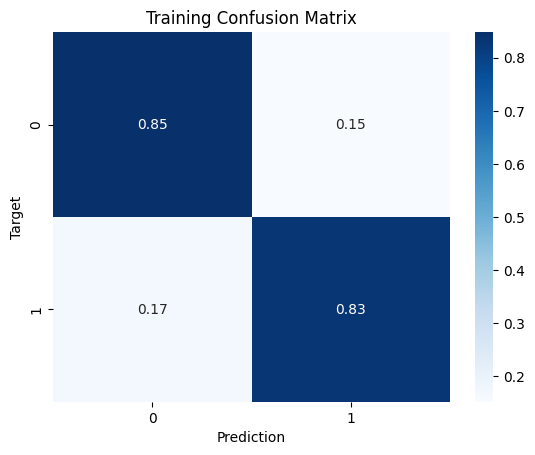

F1 SCORE for Validation: 0.68
Area under ROC score on Validation dataset: 0.91%


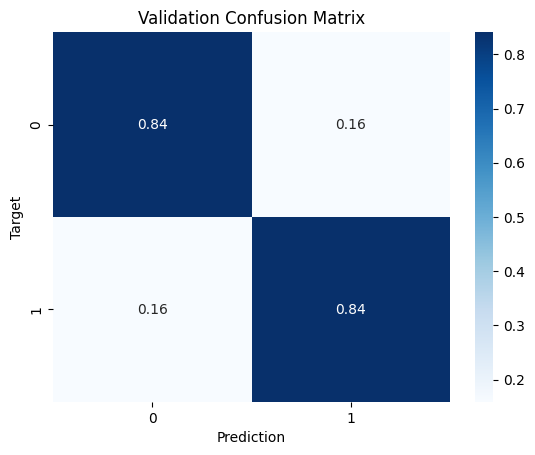

['model_polin_2_pipeline.pkl']

In [54]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', MinMaxScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Стоврюємо пайплайн, який спочатку запускає препроцесинг, потім тренуєм модель
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', class_weight='balanced'))
])

# Тренуємо пайплайн
model_pipeline.fit(train_inputs, train_targets)
train_preds = predict_and_plot(model_pipeline, train_inputs, train_targets, 'Training')
val_preds = predict_and_plot(model_pipeline, val_inputs, val_targets, 'Validation')
joblib.dump(model_pipeline, 'model_polin_2_pipeline.pkl')

Ця можель по всім показникам стала перформити краще. Бачимо, що Area under ROC стала > 90%. Бачимо що результати на тренувальних та валідаційних даних майже однакові тому тут немає overfit чи underfit, а значить модель доволі непогано генералізує.

**Завдання 3**. Тепер давайте створимо ще новий пайплайн, тільки тепер поліноміальні ознаки згенеруємо до степені 4. Зробіть висновок про якість моделі. Якщо вам подобається резульат якоїсь з моделей в цьому ДЗ - рекомендую зробити submission в змаганні.

F1 SCORE for Training: 0.71
Area under ROC score on Training dataset: 0.93%


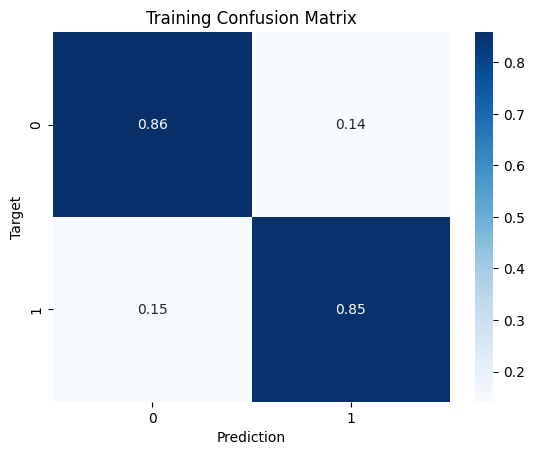

F1 SCORE for Validation: 0.71
Area under ROC score on Validation dataset: 0.93%


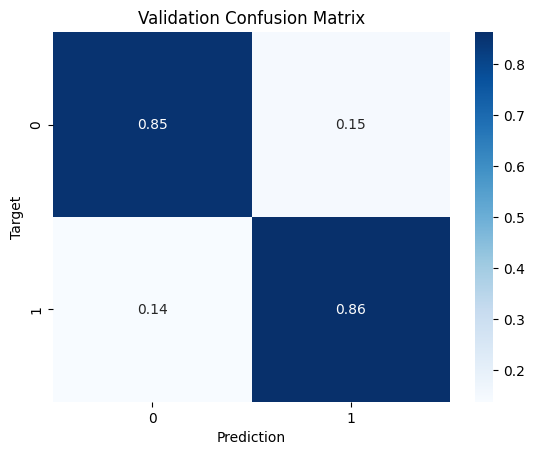

['model_polin_4_pipeline.pkl']

In [55]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('poly', PolynomialFeatures(degree=4, include_bias=False)),
    ('scaler', MinMaxScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Стоврюємо пайплайн, який спочатку запускає препроцесинг, потім тренуєм модель
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', class_weight='balanced'))
])

# Тренуємо пайплайн
model_pipeline.fit(train_inputs, train_targets)
train_preds = predict_and_plot(model_pipeline, train_inputs, train_targets, 'Training')
val_preds = predict_and_plot(model_pipeline, val_inputs, val_targets, 'Validation')
joblib.dump(model_pipeline, 'model_polin_4_pipeline.pkl')

Поліноміальна модель з 4 сетепенню заперформила дуже добре, при чому результати на тренувальних та валідаційних даних однакові, що свідчить про хорошу здатність моделі генералізувати дані.

In [34]:
test_raw_df = pd.read_csv("test.csv")
predictions = model_pipeline.predict_proba(test_raw_df)[:, 1]

test_raw_df['Exited'] = predictions

test_raw_df.head()

sample_submission_df = pd.read_csv('sample_submission.csv')
print(sample_submission_df.head())

sample_submission_df['Exited'] = test_raw_df['Exited']
print(sample_submission_df.head())

sample_submission_df.to_csv('submission_poli4reg.csv', index=False)
pd.read_csv('submission_poli4reg.csv').head()

      id  Exited
0  15000     0.5
1  15001     0.5
2  15002     0.5
3  15003     0.5
4  15004     0.5
      id    Exited
0  15000  0.262198
1  15001  0.073374
2  15002  0.211022
3  15003  0.681774
4  15004  0.085519


,id,Exited
0,15000,0.262198
1,15001,0.073374
2,15002,0.211022
3,15003,0.681774
4,15004,0.085519


**Завдання 4. Перенавчання і регуляризація**.

  Скачайте набір даних `regression_data.csv`. Звичайте набір даних з `regression_data.csv`, розбийте на train і test (в тест 20%) і натренуйте модель лінійної регресії з масштабуванням числових ознак і поліноміальними ознаками до степені **5 включно**.

  Виміряйте якість прогностичної моделі і зробіть висновок, чи модель хороша, чи вона добре генералізує?


In [106]:
reg_df = pd.read_csv("regression_data.csv")
reg_df.describe()

,feature_1,feature_2,feature_3,feature_4,feature_5,target
count,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000
mean,-0.082039,-0.017872,0.092293,-0.076084,0.053098,-3.902984
std,0.941214,1.065887,0.978557,0.910588,1.004498,45.466621
min,-3.241267,-2.619745,-1.913280,-2.211135,-2.301921,-111.753810
25%,-0.699726,-0.756351,-0.553649,-0.730367,-0.772825,-37.339533
50%,-0.066080,-0.161286,0.120296,0.018418,0.013002,-0.641298
75%,0.529804,0.679598,0.624120,0.519347,0.787085,25.464414
max,2.122156,3.852731,3.078881,2.314659,2.075401,115.125907


In [107]:
train_reg_df, val_reg_df = train_test_split(reg_df, test_size=0.2, random_state=42,)

input_reg_cols = list(train_reg_df.columns)[:-1]
target_reg_col = 'target'
train_reg_inputs, train_reg_targets = train_reg_df[input_reg_cols], train_reg_df[target_reg_col]
val_reg_inputs, val_reg_targets = val_reg_df[input_reg_cols], val_reg_df[target_reg_col]

numeric_reg_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('poly', PolynomialFeatures(degree=5, include_bias=False)),
    ('scaler', MinMaxScaler())
])

preprocessor_reg = ColumnTransformer(
    transformers=[
        ('num', numeric_reg_transformer, input_reg_cols),
    ])

model_reg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_reg),
    ('regressor', LinearRegression())
])

model_reg_pipeline.fit(train_reg_inputs, train_reg_targets)

def evaluate_model(model, inputs, targets, name):
    preds = model.predict(inputs)
    mse = root_mean_squared_error(targets, preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(targets, preds)
    print(f"{name} Metrics:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  R^2: {r2:.4f}")

    return preds

train_reg_preds = evaluate_model(model_reg_pipeline, train_reg_inputs, train_reg_targets, 'Training')
val_reg_preds = evaluate_model(model_reg_pipeline, val_reg_inputs, val_reg_targets, 'Validation')

linear_model = model_reg_pipeline.named_steps['regressor']
weights = linear_model.coef_
intercept = linear_model.intercept_

print("Ваги моделі (коефіцієнти):", weights)
print("Інтерсепт:", intercept)

Training Metrics:
  RMSE: 0.0000
  R^2: 1.0000
Validation Metrics:
  RMSE: 3.5161
  R^2: 0.9345
Ваги моделі (коефіцієнти): [-1.64781059e+00  5.24368081e+00 -5.06624740e+00  2.03890244e+02
 -7.14195392e+00  8.85940724e+00  5.48455201e+00 -1.39391080e+00
 -1.33999095e+01  1.08591451e+01 -4.03944113e+00  5.30035184e+00
 -1.19490909e+01  2.35019742e+00 -1.49906752e+00  1.23151715e+00
 -1.44635264e+00 -3.19178684e+00 -1.35257726e+01  3.46534710e+00
  3.82849450e+00 -1.29207790e+00  4.04822350e+00  1.27138767e+01
  1.22046457e+01 -1.80049188e+00  3.11704543e+00  7.34170356e+00
  1.46676026e+00 -4.23117026e+00  8.88675307e+00 -5.79526339e+00
 -5.51045379e-01 -6.74744797e+00 -6.87630016e+00  9.33673528e+00
  6.06095471e+00  1.27335464e+01 -2.85943549e+00 -1.33724796e+01
  1.12489567e+00 -1.19290599e+01 -1.60555724e+01 -6.98488064e+00
  6.17168628e+00  1.26481783e+01  8.09268681e+00 -2.97618609e+00
  3.88101609e+00 -3.46166584e+00  3.93975278e+00  1.44333192e+01
  1.49101280e+01  1.19906241e+01

Бачимо, що на тренувальних даних модель заперформила ідеально, а на валідаційних дуже велике RMSE. Спостерігаємо перенавчання моделі. Також бачимо дуже великі значення ваг.

**Завдання 5**. Натренуйте моделі Lasso(), Ridge(), ElasaticNet() на цих даних (з поліном ознаками до степені 20 включно), порівняйте якість з тою, яка була отримана з лінійною регресією. Яка модель найкраще генералізує і чому на ваш погляд (можливо треба буде для відповіді зробити додатковий аналіз ознак)?

In [108]:
numeric_reg_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('poly', PolynomialFeatures(degree=20, include_bias=False)),
    ('scaler', MinMaxScaler())
])

preprocessor_reg = ColumnTransformer(
    transformers=[
        ('num', numeric_reg_transformer, input_reg_cols),
    ])

def train_and_evaluate_model(model, model_name):
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor_reg),
        ('regressor', model)
    ])
    pipeline.fit(train_reg_inputs, train_reg_targets)

    # Прогнозування
    train_preds = pipeline.predict(train_reg_inputs)
    val_preds = pipeline.predict(val_reg_inputs)

    # Метрики
    train_rmse = root_mean_squared_error(train_reg_targets, train_preds)
    val_rmse = root_mean_squared_error(val_reg_targets, val_preds)
    train_r2 = r2_score(train_reg_targets, train_preds)
    val_r2 = r2_score(val_reg_targets, val_preds)

    print(f"=== {model_name} ===")
    print(f"Training RMSE: {train_rmse:.4f}, R^2: {train_r2:.4f}")
    print(f"Validation RMSE: {val_rmse:.4f}, R^2: {val_r2:.4f}\n")

    return pipeline

# Тренування моделей
linear_model = train_and_evaluate_model(LinearRegression(), "Linear Regression")
lasso_model = train_and_evaluate_model(Lasso(alpha=0.001, max_iter=10000), "Lasso Regression")
ridge_model = train_and_evaluate_model(Ridge(alpha=1.0), "Ridge Regression")
elasticnet_model = train_and_evaluate_model(ElasticNet(alpha=0.01, l1_ratio=0.5, max_iter=10000), "ElasticNet Regression")


=== Linear Regression ===
Training RMSE: 0.0000, R^2: 1.0000
Validation RMSE: 15.6743, R^2: 0.8947

=== Lasso Regression ===
Training RMSE: 0.5407, R^2: 0.9998
Validation RMSE: 6.1142, R^2: 0.9840

=== Ridge Regression ===
Training RMSE: 8.5978, R^2: 0.9620
Validation RMSE: 76.5627, R^2: -1.5125

=== ElasticNet Regression ===
Training RMSE: 5.7099, R^2: 0.9833
Validation RMSE: 19.7731, R^2: 0.8324



Загалом результати усіх моделей погані, бачимо, що всі моделі погано працюють з новими даним. Основні причини - дуже мало даних (всього 129 записів), використовуючи ступінь 20 ми генеруємо дуже багато додаткових фічей. Краще всьго себе показала лінійна модель з поліномом 5 степеня. Бачимо, що також лассо регрессія у порівннні з іншими моделями показала себе краще. Ця модель занулює коєфіцієнти, спробуємо вибрати ознаки з високою кореляцією з таргетом для покращення моделі.

Колонки з кореляцією > 0.15: ['feature_4', 'feature_5']


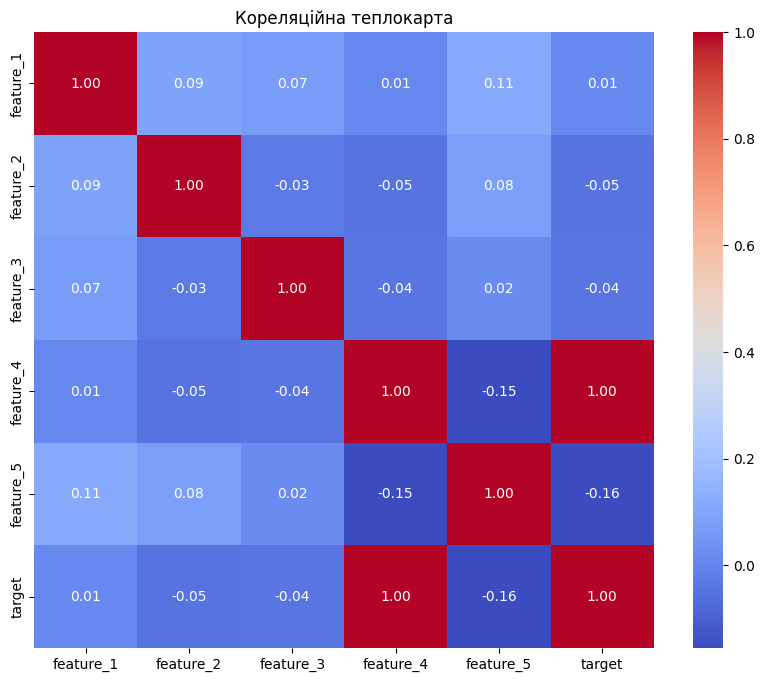

In [109]:
correlation_matrix = reg_df.corr()
target_correlation = correlation_matrix['target']
selected_columns = target_correlation[abs(target_correlation) > 0.15].index.tolist()

selected_columns.remove('target')

print("Колонки з кореляцією > 0.15:", selected_columns)

plt.figure(figsize=(10, 8))
sns.heatmap(reg_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Кореляційна теплокарта')
plt.show()


In [124]:
preprocessor_reg = ColumnTransformer(
    transformers=[
        ('num', numeric_reg_transformer, selected_columns),
    ])

linear_model = train_and_evaluate_model(LinearRegression(), "Linear Regression")
lasso_model = train_and_evaluate_model(Lasso(alpha=0.1, max_iter=10000), "Lasso Regression")
ridge_model = train_and_evaluate_model(Ridge(alpha=1.0), "Ridge Regression")
elasticnet_model = train_and_evaluate_model(ElasticNet(alpha=0.01, l1_ratio=0.5, max_iter=10000), "ElasticNet Regression")


=== Linear Regression ===
Training RMSE: 0.0000, R^2: 1.0000
Validation RMSE: 14946256.3730, R^2: -95749810483.4864

=== Lasso Regression ===
Training RMSE: 1.1986, R^2: 0.9993
Validation RMSE: 1.0046, R^2: 0.9996

=== Ridge Regression ===
Training RMSE: 8.9043, R^2: 0.9593
Validation RMSE: 12.9665, R^2: 0.9279

=== ElasticNet Regression ===
Training RMSE: 5.7800, R^2: 0.9828
Validation RMSE: 6.6650, R^2: 0.9810



Показники моделей з регуляризацією покращилися. Найкраще показала себе лассо регрессія.